# Almacenes de datos API

## Librerías

In [1]:
# Modelo Deep Learning
import modulos.modelo_lstm as mlstm  

C:\Users\Hp\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Modelo Web Scraping
import modulos.web_scraping as web_sc

In [3]:
# Funciones Generales
import modulos.funciones_generales as fg

In [4]:
# Visualización Sentimientos
import modulos.sentimientos_viz as s_viz

In [5]:
from pymongo import MongoClient # Librería para conexión con Mongo

In [6]:
# Importando Keras para Deep Learning
from tensorflow import keras

In [7]:
import json # Para lectura de archivo de configuración

## Archivo Config

In [8]:
def str2bool(v):
  return v.lower() in ("yes", "true", "t", "1")

with open("config_file/config.json") as json_data_file:
    config = json.load(json_data_file)

## Downloading and plotting data

Number data points: 5919 from 1999-11-01 to 2023-05-10


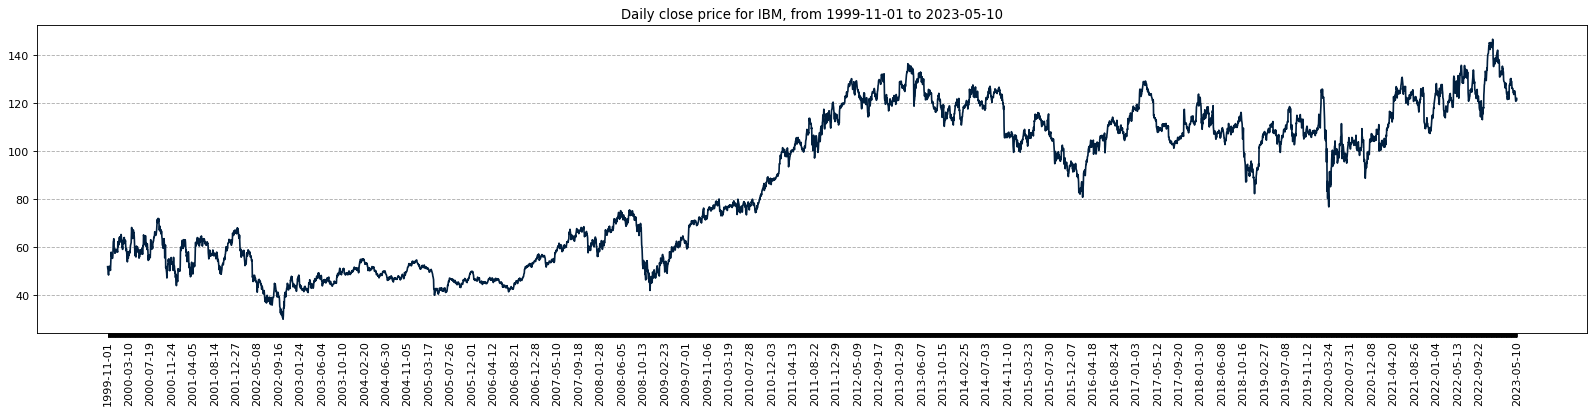

In [35]:
fechas, valores, num_data_points, display_date_range = fg.descargar_datos(config, plot=str2bool(config["plots"]["show_plots"]))

## Obteniendo data en pandas

In [10]:
data_target,target = fg.obtener_data_pandas(fechas, valores, '2000-01-01')

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test, sc_train = fg.split_train_val_test(target,  int(config["data"]["test_split_size"]), int(config["data"]["validation_split_size"])
                                                                                , int(config["data"]["window_size"]) )

Número de registros y columnas (training): (5847, 20, 1)
Número de registros y columnas (validation): (2, 20, 1)
Número de registros y columnas (test): (7, 20, 1)


## Modelo Deep Learning LSTM y learning rate cíclico

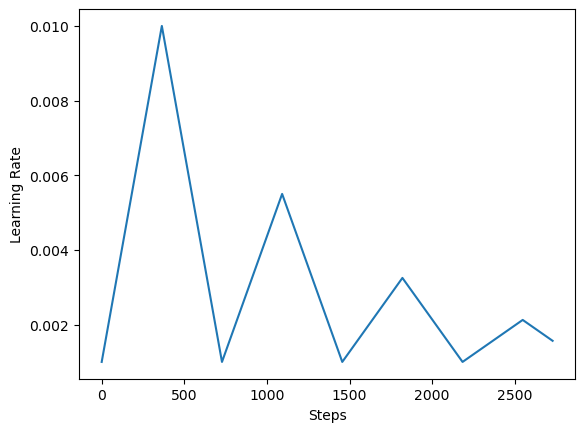

In [12]:
# Creando el learning rate cíclico
clr = mlstm.crear_learning_rate_ciclico(config, X_train)

In [13]:
# Archivo de configuración del modelo
config_file = {
    "input_shape": X_train.shape[1],
    "lstm_size": int(config["model"]["lstm_size"]),
    "dropout": float(config["model"]["dropout"])
}

In [14]:
# Llamando la clase MyModel de mlstm
model = mlstm.MyModel(config_file)
# Construyendo el modelo
model.build((None, config_file["input_shape"], 1))
# Compilando el modelo
model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])

In [15]:
# Resumen del modelo
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  4352      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 lstm_1 (LSTM)               multiple                  8320      
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense (Dense)               multiple                  33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Entrenando el modelo
model.fit(X_train, y_train, epochs=int(config["training"]["epochs"]), batch_size=int(config["training"]["batch_size"]),validation_data=(X_val, y_val))

Epoch 1/15
183/183 [==============================] - 23s 55ms/step - loss: 0.1980 - root_mean_squared_error: 0.3249 - val_loss: 0.0433 - val_root_mean_squared_error: 0.0433
Epoch 2/15
183/183 [==============================] - 7s 39ms/step - loss: 0.1082 - root_mean_squared_error: 0.1426 - val_loss: 0.0858 - val_root_mean_squared_error: 0.0858
Epoch 3/15
183/183 [==============================] - 8s 45ms/step - loss: 0.1034 - root_mean_squared_error: 0.1362 - val_loss: 0.0703 - val_root_mean_squared_error: 0.0704
Epoch 4/15
183/183 [==============================] - 9s 51ms/step - loss: 0.0983 - root_mean_squared_error: 0.1288 - val_loss: 0.0413 - val_root_mean_squared_error: 0.0416
Epoch 5/15
183/183 [==============================] - 11s 62ms/step - loss: 0.0945 - root_mean_squared_error: 0.1237 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0127
Epoch 6/15
183/183 [==============================] - 10s 57ms/step - loss: 0.0957 - root_mean_squared_error: 0.1260 - val_loss: 0.09

In [17]:
# Evaluando el modelo en test
print("Evaluando en test data")
results = model.evaluate(X_test,y_test, batch_size= int(config["training"]["batch_size"]))
print("test mse, test rmse:", results)

Evaluando en test data
1/1 [==============================] - 0s 95ms/step - loss: 0.0472 - root_mean_squared_error: 0.0590
test mse, test rmse: [0.047157831490039825, 0.058978479355573654]


In [18]:
# Haciendo predicciones sobre test
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc_train.inverse_transform(predicted_stock_price)

1/1 [==============================] - 2s 2s/step


## Visualizaciones de resultados LSTM

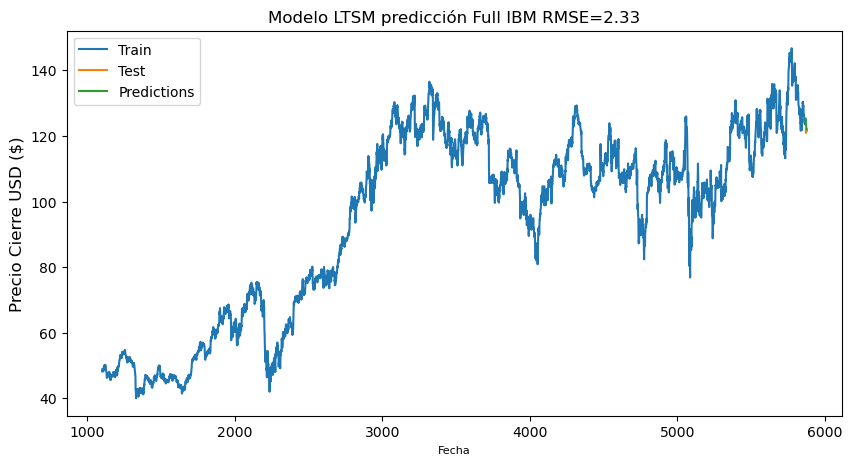

In [19]:
# Visualización de serie de tiempo con predicciones
fg.plot_predictions(config, predicted_stock_price, X_train, fechas,data_target, "Full")

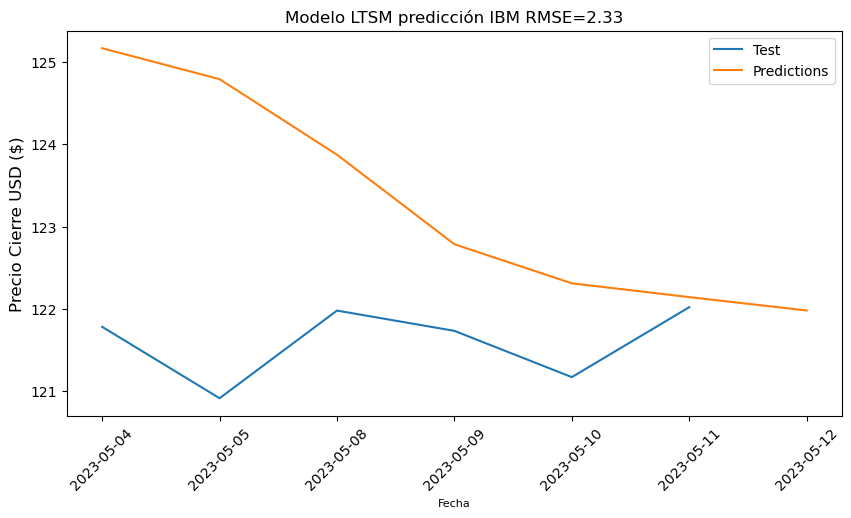

In [20]:
# Visualización de serie de tiempo solo predicciones vs test
RMSE, lista_fechas = fg.plot_predictions(config, predicted_stock_price, X_train,fechas,data_target, "Pred")

## Web Scraping - Análisis de sentimientos

In [37]:
titulares = web_sc.extraer_noticias(config) # Extrayendo noticias.
df = web_sc.predicciones_sentimientos(titulares, float(config["plots"]["threshold"])) # Obteniendo análisis de sentimientos en noticias.

C:\Users\Hp\Documents\GitHub\ALM-DE-DATOS\PRACTICAS\PRACTICA 3\modulos\web_scraping.py:44: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 44 of the file C:\Users\Hp\Documents\GitHub\ALM-DE-DATOS\PRACTICAS\PRACTICA 3\modulos\web_scraping.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(html) #Conexión entre Selenium y BeautifulSoup


## Análisis de resultados en sentimientos

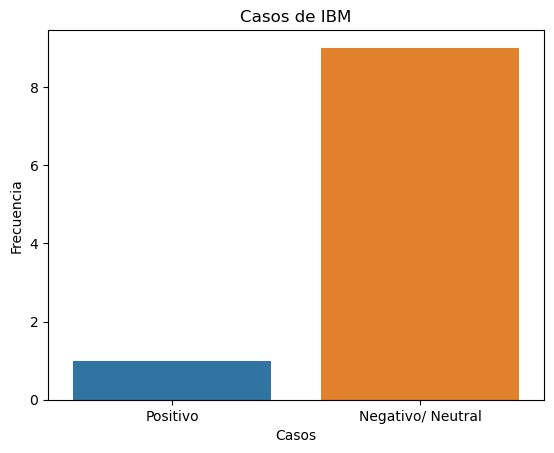

In [38]:
s_viz.casos_plot(df,config)

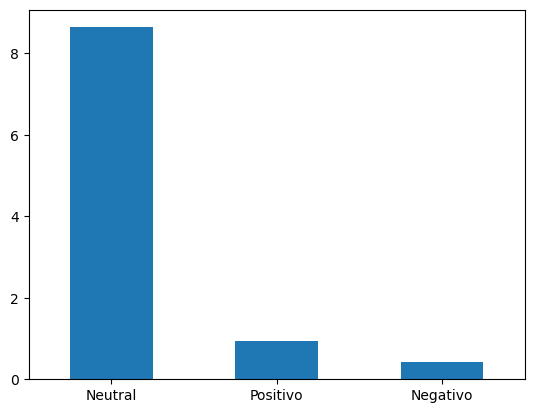

In [24]:
s_viz.bar_plot(df)

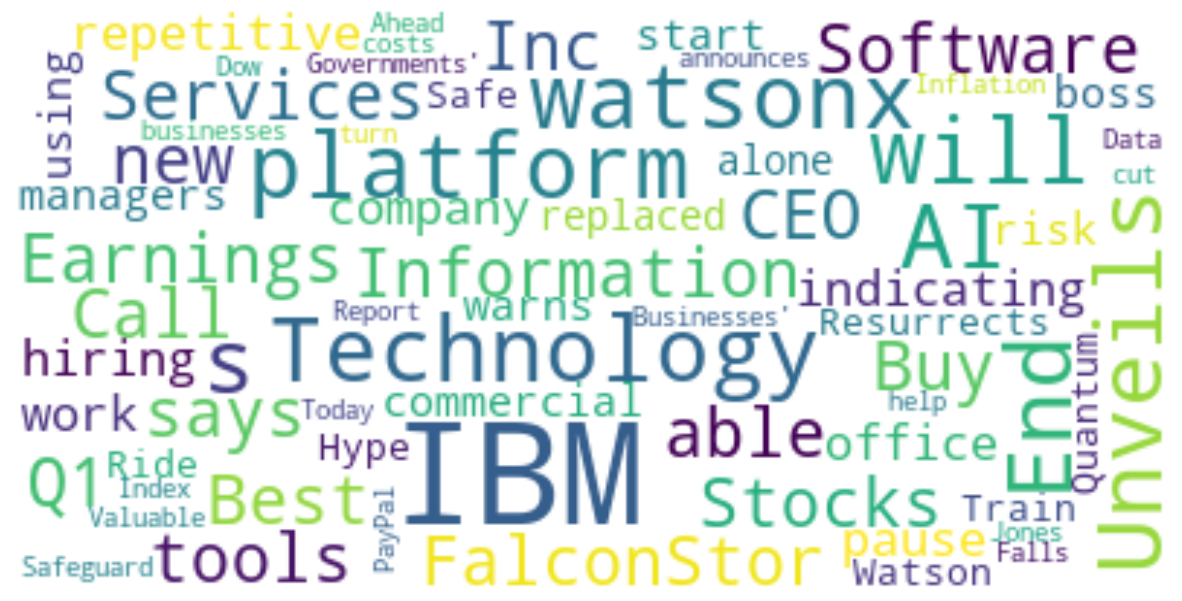

In [25]:
s_viz.word_cloud(df)

In [26]:
df

,Titulares,Positivos,neg,neu,pos,compound,Threshold,Timestamp,Positivos_texto
0,12 Best Information Technology Services Stocks...,1,0.000,0.625,0.375,0.6369,0.5,2023-05-11 18:23:14.573761,Positivo
1,Q1 2023 FalconStor Software Inc Earnings Call,0,0.000,1.000,0.000,0.0000,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral
2,IBM’s CEO says its new A.I. tools will be able...,0,0.000,1.000,0.000,0.0000,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral
3,IBM commercial boss warns managers to start us...,0,0.192,0.713,0.095,-0.1926,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral
4,IBM Resurrects Watson to Ride the AI Hype Train,0,0.000,1.000,0.000,0.0000,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral
5,IBM Unveils End-to-End Quantum-Safe Technology...,0,0.000,0.809,0.191,0.3818,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral
6,IBM announces AI platform watsonx to help busi...,0,0.000,0.722,0.278,0.4019,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral
7,Dow Jones Today: Index Falls Ahead of Inflatio...,0,0.000,1.000,0.000,0.0000,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral
8,IBM Unveils WatsonX Platform,0,0.000,1.000,0.000,0.0000,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral
9,"PayPal, IBM turn to A.I. to cut costs",0,0.231,0.769,0.000,-0.2732,0.5,2023-05-11 18:23:14.573761,Negativo/ Neutral


## Guardado de resultados en MongoDB

### Resultados LSTM

In [27]:
target

array([[62.3646944591886],
       [60.2464453542817],
       [62.3646944591886],
       ...,
       [121.732296670195],
       [121.17],
       [122.02]], dtype=object)

In [28]:
prediccion = round(float(predicted_stock_price[-1]),3)
valor_actual = round(float(target[-1]),3)
diferencia = round(prediccion - valor_actual,3)
direccion = "positivo" if diferencia > 0 else "negativo"
fecha_prediccion = lista_fechas[-1:][0]
dia_cierre = lista_fechas[-2:-1][0]
RMSE =round(float(RMSE),3)
tiempo = str(df['Timestamp'][0])
version = config['model']['version']
company = config['alpha_vantage']['symbol']

### Resultados noticias

In [29]:
positivos = int(df.Positivos.sum())
num_noticias = len(df.Positivos)
threshold = float(df.Threshold[0])
conclusion_noticias= "Positivos" if df.Positivos.mean()>=0.5 else "Negativo/ Neutral" 

### Guardado de datos

In [30]:
client= MongoClient('mongodb://localhost:27017')
db= client['stock_market'] #Conectamos con la bbdd
predicciones = db['predicciones'] #accedemos a una colección

In [31]:
prediccion_documento = {"stock_prediction": {
                "timestamp": tiempo,
                "version_modelo": version,
                "company": company,
                "direccion": direccion,
                "fecha_prediccion": fecha_prediccion,
                "dia_cierre": dia_cierre,
                "prediccion": prediccion,
                "valor_actual": valor_actual,
                "diferencia":diferencia,
                "RMSE": RMSE
    },
            "sentiment_analysis": {
                "num_noticias": num_noticias,
                "positivos": positivos,
                "threshold": threshold,
                "conclusion_noticias": conclusion_noticias
    }} # creamos un documento
prediccion_documento

{'stock_prediction': {'timestamp': '2023-05-11 18:23:14.573761',
  'version_modelo': 'v1',
  'company': 'IBM',
  'direccion': 'negativo',
  'fecha_prediccion': '2023-05-12',
  'dia_cierre': '2023-05-11',
  'prediccion': 121.98,
  'valor_actual': 122.02,
  'diferencia': -0.04,
  'RMSE': 2.33},
 'sentiment_analysis': {'num_noticias': 10,
  'positivos': 1,
  'threshold': 0.5,
  'conclusion_noticias': 'Negativo/ Neutral'}}

In [32]:
#condicion = {'stock_prediction.version_modelo': version}
#predicciones.remove(condicion) # por si necesitamos borrar

In [33]:
resultado = predicciones.insert_one(prediccion_documento)#insertamos el documento 
print(resultado)#mostramos el resultado de insertar

### Comprobando resultados

In [34]:
condicion = {'stock_prediction.version_modelo': 'v1'} # buscamos resultados del modelo con versión v1
resultado = predicciones.find(condicion)
for documento in resultado:
    print(documento)

{'_id': ObjectId('645bcb432a01baf8468e5f02'), 'stock_prediction': {'timestamp': '2023-05-10 18:33:29.124778', 'version_modelo': 'v1', 'company': 'IBM', 'direccion': 'negativo', 'fecha_prediccion': '2023-05-11', 'dia_cierre': '2023-05-10', 'prediccion': 121.074, 'valor_actual': 121.17, 'diferencia': -0.096, 'RMSE': 1.62}, 'sentiment_analysis': {'num_noticias': 10, 'positivos': 0, 'threshold': 0.5, 'conclusion_noticias': 'Negativo/ Neutral'}}
{'_id': ObjectId('645cba3b613781f605c244fa'), 'stock_prediction': {'timestamp': '2023-05-11 11:49:45.768362', 'version_modelo': 'v1', 'company': 'MSFT', 'direccion': 'negativo', 'fecha_prediccion': '2023-05-12', 'dia_cierre': '2023-05-11', 'prediccion': 299.669, 'valor_actual': 312.31, 'diferencia': -12.641, 'RMSE': 12.76}, 'sentiment_analysis': {'num_noticias': 10, 'positivos': 1, 'threshold': 0.5, 'conclusion_noticias': 'Negativo/ Neutral'}}
{'_id': ObjectId('645cbb2901b9fc6ec4e3949b'), 'stock_prediction': {'timestamp': '2023-05-11 11:53:43.798678